# Neural networks and decision boundaries

## Reference

This refers to the following paper by Szegedy _et al._:
> Intriguing properties of neural networks. 
> Christian Szegedy, Wojciech Zaremba, Ilya Sutskever, Joan Bruna, Dumitru Erhan, Ian Goodfellow, Rob Fergus
> https://cs.nyu.edu/~zaremba/docs/understanding.pdf

## Content

In this paper (especially in Sec. 4 of the paper), authors suggest that, even when using heavily trained neural networks, there exist small distortions to input images (so small that they cannot be distinguished by human eye) that can lead the network to predict an erroneous class. Authors suggest to learn these distortions (for an input image $x$ of class $y_\text{true}$ and a target class $y$) by minimizing the following quantity _via_ gradient descent over the distortion $r$:

$$l(x + r, y) + c |r|$$

## Experiments on MNIST data

Let us start by making our opinion about whether such distortions are highly probable or not, using MNIST data and a multi-layer perceptron with two hidden levels (100 units in each level).

In [1]:
%matplotlib inline

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib.pyplot as plt

print("Fetching MNIST data")
mnist = fetch_mldata("MNIST original")
# rescale the data, use the traditional train/test split
X, y = mnist.data / 255., mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print("Fitting MLP model")
np.random.seed(0)
model = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=200, verbose=10, random_state=0)
model.fit(X_train, y_train)
print("Training set score: %f" % model.score(X_train, y_train))
print("Test set score: %f" % model.score(X_test, y_test))

Fetching MNIST data
Fitting MLP model
Iteration 1, loss = 0.39140706
Iteration 2, loss = 0.15646316
Iteration 3, loss = 0.11339605
Iteration 4, loss = 0.08722611
Iteration 5, loss = 0.07000673
Iteration 6, loss = 0.05705897
Iteration 7, loss = 0.04800349
Iteration 8, loss = 0.03982679
Iteration 9, loss = 0.03358962
Iteration 10, loss = 0.02886357
Iteration 11, loss = 0.02515533
Iteration 12, loss = 0.02028903
Iteration 13, loss = 0.01679386
Iteration 14, loss = 0.01411671
Iteration 15, loss = 0.01357185
Iteration 16, loss = 0.01143521
Iteration 17, loss = 0.01035407
Iteration 18, loss = 0.01072630
Iteration 19, loss = 0.00943709
Iteration 20, loss = 0.00667420
Iteration 21, loss = 0.01037049
Iteration 22, loss = 0.01127165
Iteration 23, loss = 0.00519513
Iteration 24, loss = 0.00430628
Iteration 25, loss = 0.00334825
Iteration 26, loss = 0.00557092
Iteration 27, loss = 0.01002648
Iteration 28, loss = 0.00598333
Training loss did not improve more than tol=0.000100 for two consecutive ep

Now, let us focus on test samples that were correctly predicted by the model:

In [2]:
print(y_test.shape)

indices = model.predict(X_test) == y_test
X_test = X_test[indices]
y_test = y_test[indices]

print(y_test.shape)

(10000,)
(9797,)


epsilon=0.0010: p=0.000000
epsilon=0.0063: p=0.000005
epsilon=0.0398: p=0.000082
epsilon=0.2512: p=0.000429
epsilon=1.5849: p=0.004078
epsilon=10.0000: p=0.157895


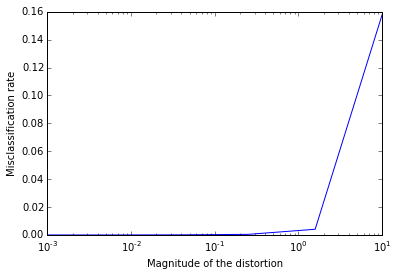

In [3]:
epsilon_values = np.logspace(-3, 1, 6)
probas = [0.] * len(epsilon_values)
for idx_eps, epsilon in enumerate(epsilon_values):
    n_trials = 20
    cpt = []
    for i_trial in range(n_trials):
        r = np.random.randn(X.shape[1])
        r *= epsilon / np.linalg.norm(r)
        shifted_x = X_test + r.reshape((1, -1))
        cpt.append(np.sum(model.predict(shifted_x) != y_test))
    probas[idx_eps] = np.mean(cpt) / X_test.shape[0]
    print("epsilon=%.4f: p=%.6f" % (epsilon, probas[idx_eps]))

plt.figure()
plt.semilogx(epsilon_values, probas)
plt.xlabel("Magnitude of the distortion")
plt.ylabel("Misclassification rate");

The probas seem to stay relatively low. Let us now visualize some samples for which misclassification occurs.

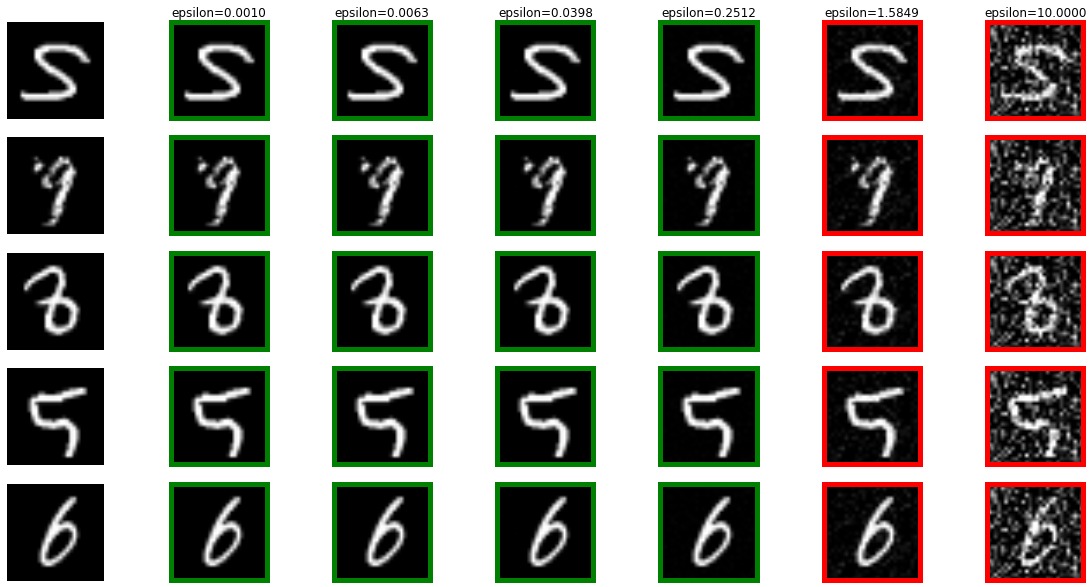

In [4]:
epsilon_values = np.logspace(-3, 1, 6)
n_images_shown = 5

images = np.zeros((len(epsilon_values), X_test.shape[0], X_test.shape[1]))
incorrect = np.zeros((len(epsilon_values), X_test.shape[0]))

for idx_eps, epsilon in enumerate(epsilon_values):
    r = np.random.randn(X.shape[1])
    r *= epsilon / np.linalg.norm(r)
    shifted_x = X_test + r.reshape((1, -1))
    disagreement = model.predict(shifted_x) != y_test
    images[idx_eps] = shifted_x.copy()
    incorrect[idx_eps] = disagreement.copy()
    
indices_images = np.argsort(np.sum(incorrect, axis=0))[-n_images_shown:]
images = images[:, indices_images, :]
incorrect = incorrect[:, indices_images]

plt.figure(figsize=(20, 10))
for img_id in range(n_images_shown):
    plt.subplot(n_images_shown, len(epsilon_values) + 1, img_id * (len(epsilon_values) + 1) + 1)
    plt.imshow(X_test[indices_images[img_id]].reshape(28, 28), cmap=plt.cm.gray, vmin=0., vmax=1.)
    plt.xticks([])
    plt.yticks([])
for idx_eps, epsilon in enumerate(epsilon_values):
    for img_id in range(n_images_shown):
        ax = plt.subplot(n_images_shown, len(epsilon_values) + 1, img_id * (len(epsilon_values) + 1) + idx_eps + 2)
        if img_id == 0:
            plt.title("epsilon=%.4f" % epsilon)
        plt.imshow(images[idx_eps, img_id].reshape(28, 28), cmap=plt.cm.gray, vmin=0., vmax=1.)
        plt.xticks([])
        plt.yticks([])
        if incorrect[idx_eps, img_id]:
            for pos in ["bottom", "top", "right", "left"]:
                ax.spines[pos].set_color('red')
                ax.spines[pos].set_linewidth(5)
        else:
            for pos in ["bottom", "top", "right", "left"]:
                ax.spines[pos].set_color('green')
                ax.spines[pos].set_linewidth(5)